# Introduction

### Problem Statement

When I was young I was a fan of the show Pokemon. Pokemon cards cards are fun to collect and can even be a good investment as some rare cards sell for thousands of dollars. I'm want to find the best way for someone to upload their pokemon card collection online. This could be a fast way to  record someone's collection, or even be made compatible with a Pokemon computer game. The goal of my project is to find a way for card collectors to link their collection with their online accounts or just to store their cards electronically. Typing in Pokemonnames on a phone or table can be cumbersome and the ability to scan an image of a card to find out how much it is worth would be very useful to players and collectors. This is also a good opportunity to learn how Nueral Networks best learn patterns to classify images.

### Imports

In [2]:
# These modules are necesssary
#%pip install simple_image_download
#%pip install pokemontcgsdk
#%pip install opencv-python

In [3]:
from pokemontcgsdk import Card
from simple_image_download import simple_image_download as simp
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import shutil 
import random
import tensorflow as tf
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import urllib.request
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping

# Data Source

The input Data for this project will be general pictures of Pokemon and pictures of Pokemon Trading Cards. Images of the trading cards can
be downloaded using the Pokemon tcg API from https://pokemontcg.io/   <br>

The general pictures of Pokemon are used from this PokemonClassifier Dataset with 7,000 Labeled Pokemon https://www.kaggle.com/lantian773030/pokemonclassification/activity <br>


Additional general Pokemon images are downloading using the simple_image_download module to pull images from google search results. <br>

I also used a Pokemon information dataframe to to create a dictionary useful for fetching and labeling images. I obtained a Pokemon excel file with names, types and pokedex numbers from https://www.reddit.com/r/pokemon/comments/1qrnw8/i_made_a_few_plain_text_printer_friendly_pokemon/  

# Setup

In this project I will use three image classification models. The first model will will be trained on general pokemon images to classify Pokemon as a test. Next I will experiment with to find the best ways to classify Pokemon trading cards. The second model will be trained on general images to classify Pokemon trading cards, and the third will be trained on cropped out images of Pokemon trading cards to classify Pokemon trading cards. Data from kaggle is put in Poke_train folder while tcg images are placed in tcg folders. This project will be limited to generation 1 Pokemon meaning it will classify 151 types of Pokemon. For this reason 'Alohan Sandslash' is not used in the original Kaggle dataset.

After removing Alohan Sandlash folder, I download 90 pictuers of Nidoran male and Nidoran Female. I use simple_image_downloader for this.

In [35]:
#Instantiate simple_image_download 
# response = simp.simple_image_download 

In [ ]:
# Creates folder with google image search pictures of the Popkemon Nidoran male and female
# response.download(response(), keywords='Nidoran', limit=90)

images are manually sorted and moved to the training folder as the picturs are a mix of Nidoran male and Nidoran female and they need to be put in the correct folder.
The simple images folder is then deleted.

In [38]:
len(os.listdir(f"{path}/Nidoran♀"))

36

In [39]:
len(os.listdir(f"{path}/Nidoran♂"))

36

I found 36 good images for both Nidoran classes. This is close to the average number of images per class from the Kaggle dataset (around 45)

In [8]:
# Set Path variable to use in os code
path = "../Data/PokemonData/Poke_train"

In [9]:
len(os.listdir(path))

151

In [42]:
#Create Folders for poke_tcg_train

In [43]:
# Code to Download download tcg images to the appropriate folder
def tcg_data(pkmn_list):
    for pkmn in pkmn_list:
        counter = 1
        for card in Card.where(q='name:' + pkmn.lower()):
            r = requests.get(card.images.small).content
            with open(f"Data/PokemonData/Poke_train_tcg/{pkmn}-pic-{counter}.png", "wb+") as f:
                f.write(r)
                f.close()
            counter += 1

There are 151 Classes as expected.

# Exploratory Data Analysis

Count number of image samples for each class. (Current directory for written code is the capstone-project_master folder)

In [12]:
# create list of all classes
classes = os.listdir(path)
classes[:5] # list first five classes

['Abra', 'Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine']

In [13]:
# Create a dictionary where the key is the Pokemon name, and the value is the number of images of that Pokemon
sample_list_1 = []
sample_list_2 = []
for i in range(len(os.listdir(f"{path}"))):
    sample_list_1.append(classes[i])
    sample_list_2.append(len(os.listdir(f"{path}/{classes[i]}")))

sample_dict = dict(zip(sample_list_1, sample_list_2))

In [17]:
# I have 35 sample images of Abra
sample_dict['Abra']

35

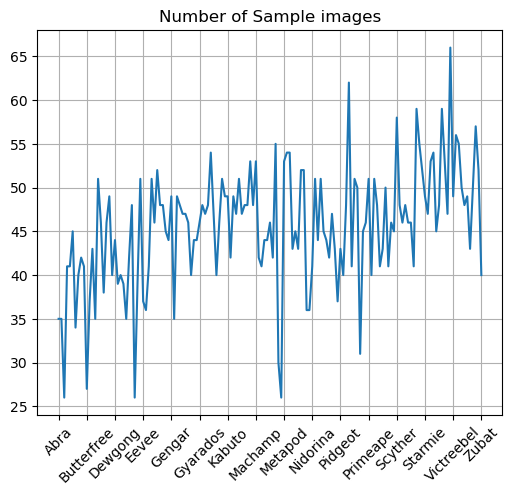

In [24]:
#Create plot of classes vs number of samles per class
x = list(sample_dict.keys())
y = list(sample_dict.values())
plt.figure(figsize=(6,5))
plot = plt.plot(x, y)
plt.xticks(x[0::10], rotation=45) #show only every 10th value on X axis for readability
plt.grid()
plt.title("Number of Sample images")
plt.show()

There is a good deal of variance in number of sample images

In [25]:
top_5 = list(sample_dict.values())
top_5.sort(reverse=True)
top_5[:5]

[66, 62, 59, 59, 58]

In [26]:
[list(sample_dict.keys())[list(sample_dict.values()).index(i)] for i in top_5[:5]]

['Venusaur', 'Pikachu', 'Snorlax', 'Snorlax', 'Scyther']

Venusaur, Pikachu, Snorlax, and Scyther have the most sample images at 66, 62, 59, 59, and 58 respectively

In [30]:
# find average sample size using values in poke_dict
res = 0
for val in sample_dict.values():
    res += val
  
# using len() to get total keys for mean computation
res = res / len(sample_dict)
f"The average image sample amount is {round(res, 2)} images."

'The average image sample amount is 45.48 images.'

### Null Model

In [31]:
# Null model always predicts Venasaur
66/sum(list(sample_dict.values()))*100

0.960978450786255

The Null model with this dataset would always predict Venasaur (the class with the most images) and would have an accruacy of about 1%

# Data Preprocessing

In [44]:
train_path = 'Data\PokemonData\Poke_train'
test_path = 'Data\PokemonData\Poke_test'

In [ ]:
# Copying 15 random images from train folders to test folders
def prep_test_data(pokemon,train_path,test_path):
    pop = os.listdir(train_path+'/'+pokemon)
    test_data = random.sample(pop,15)
    #print(test_data)
    
    for f in test_data:
        shutil.copy(train_path+'/'+pokemon+'/'+f,test_path+'/'+pokemon+'/')

# Training the Model

# Results

# Conclusion

# References